#### Ref

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe?hl=pt-br

Ref - https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=q-YbjCkzw0yU


https://github.com/nlptown/nlp-notebooks/blob/master/Text%20classification%20with%20BERT%20in%20PyTorch.ipynb

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch/notebook

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [5]:
#import sys
#!{sys.executable} -m pip install numpy  transformers==4.20.0 tqdm==4.50.2 scikit-learn torch==1.11.0  fastparquet openpyxl pandas matplotlib nltk

In [4]:
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, BertTokenizer

# Using the community model
# BERT Base
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizerBert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from tqdm import tqdm
import re
import unicodedata
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from pathlib import Path
from sklearn.utils import resample

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [3]:
from src.sentenceregbr import SentenceRegBr

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
def logprint__(key,value):
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print(f'####### LOG: {dt_string} --> {key}  {value} ')


### 1. Buillding the Dataset

In [6]:
BASE_DIR = Path(os.path.abspath('')).resolve()
objSentecesRegBr = SentenceRegBr()

  Abbreviation: [1.7426] art
  Abbreviation: [1.9803] art


[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
## Load full dataset
logprint__('Loading dfFull','Full dataset')
dataset = pd.read_parquet(Path(os.path.join(BASE_DIR,'dataset','processed','dataset_treino_full_no_shuffle_16082022.parquet')), engine='fastparquet')
dataset.columns = ["category","text"]
dataset.info()

####### LOG: 16/08/2022 20:56:01 --> Loading dfFull  Full dataset 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7498 entries, 0 to 7497
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  7498 non-null   object
 1   text      7498 non-null   object
dtypes: object(2)
memory usage: 175.7+ KB


In [8]:
### Drop small documents
dataset["tokens_no_stopwords"] = dataset["text"].apply(lambda x: objSentecesRegBr.getNrTokens(x)['tokens_no_stopwords'])
dataset = dataset[dataset["tokens_no_stopwords"] > 10]
dataset.drop(["tokens_no_stopwords"],inplace=True, axis =1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7118 entries, 0 to 7497
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  7118 non-null   object
 1   text      7118 non-null   object
dtypes: object(2)
memory usage: 166.8+ KB


In [9]:
dataset["category"] = dataset["category"].apply(lambda x: 'terceiro_setor' if x == 'terceiro_setor' else 'outros')
dataset[["category"]].value_counts()

category      
outros            5864
terceiro_setor    1254
dtype: int64

In [10]:
### Ds Labels
labels = {"outros":0
          ,"terceiro_setor":1
          ,"nao_classificado":2
          }

In [11]:
dataset.head(3)

,category,text
index,,
0,terceiro_setor,ESTABELECE O REGIME JURÍDICO DAS PARCERIAS VOL...
1,terceiro_setor,ESTABELECE O REGIME JURÍDICO DAS PARCERIAS ENT...
2,terceiro_setor,ESTA LEI INSTITUI NORMAS GERAIS PARA AS PARCER...


In [12]:
## Split dataset to train, validation and test
np.random.seed(92)
df_train, df_val, df_test = np.split(dataset.sample(frac=1, random_state=42), [int(.8*len(dataset)), int(.9*len(dataset))])
logprint__('Split datasets: \n',f'Train Size: {len(df_train)}. Test Size: {len(df_test)}. Validation Size: {len(df_val)}')


####### LOG: 16/08/2022 20:57:04 --> Split datasets: 
  Train Size: 5694. Test Size: 712. Validation Size: 712 


#### Add pos-training dataset evaluated by expers

In [13]:
df_train.category.value_counts()

outros            4669
terceiro_setor    1025
Name: category, dtype: int64

In [14]:
df_train.head(2)

,category,text
index,,
996,terceiro_setor,"OS RECURSOS DO FUNDO, DEDUZIDO O NECESSÁRIO AO..."
134,terceiro_setor,O PAGAMENTO DE REMUNERAÇÃO DA EQUIPE CONTRATAD...


In [15]:
df_predict_12082022_v1 = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset','predicted_evaluated','predict_12082022_v1.xlsx')))
df_predict_12082022_v1.head(2)

,Unnamed: 0,id_sentenca,ordem,id_doc_base,tokens_total,tokens_no_stopwords,cat_sentenca,FP,text_sentenca
0,626672,65641992_SENT_7430,77,65641992,18,10,terceiro_setor,0,"EXTINTA A FUNDAÇÃO, SEUS BENS E DIREITOS PASSA..."
1,280343,6686061971_SENT_6083,1,6686061971,58,36,terceiro_setor,1,", DECRETA: ART. 1 É DECLARADA DE UTILIDADE PÚB..."


In [16]:
df_predict_15082022_v1 = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset','predicted_evaluated','predict_15082022_v1.xlsx')))
df_predict_15082022_v1.head(2)

,Unnamed: 0,id_sentenca,ordem,id_doc_base,tokens_total,tokens_no_stopwords,cat_sentenca,FP,text_sentenca
0,661109,6962271988_SENT_2327,59,6962271988,22,13,terceiro_setor,1,A CONDIÇÃO DE ASSOCIADO PERDE SE QUANDO ASSIM ...
1,840987,687262016_SENT_9704,32,687262016,167,87,terceiro_setor,0,ART. 9 O EDITAL DE CHAMAMENTO PÚBLICO ESPECIFI...


In [17]:
df_predict = pd.concat([df_predict_12082022_v1,df_predict_15082022_v1])

In [18]:
df_predict = df_predict[["FP","text_sentenca"]].copy()
df_predict.columns = ["category","text"]

In [19]:
df_predict["category"] = df_predict["category"].apply(lambda x: 'terceiro_setor' if x == 0 else 'outros' if x == 1 else x)

In [20]:
df_predict = df_predict[df_predict["category"].isin(['terceiro_setor','outros'])]

In [21]:
df_predict.drop_duplicates(inplace=True)
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  304 non-null    object
 1   text      304 non-null    object
dtypes: object(2)
memory usage: 7.1+ KB


In [22]:
df_predict.head(2)

,category,text
0,terceiro_setor,"EXTINTA A FUNDAÇÃO, SEUS BENS E DIREITOS PASSA..."
1,outros,", DECRETA: ART. 1 É DECLARADA DE UTILIDADE PÚB..."


#### Concatenate datasets

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694 entries, 996 to 6361
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5694 non-null   object
 1   text      5694 non-null   object
dtypes: object(2)
memory usage: 133.5+ KB


In [24]:
df_train = pd.concat([df_train,df_predict])

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5998 entries, 996 to 185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5998 non-null   object
 1   text      5998 non-null   object
dtypes: object(2)
memory usage: 140.6+ KB


In [26]:
### balancing class

# Separate majority and minority classes
df_majority = df_train[df_train.category=='outros']
df_minority = df_train[df_train.category=='terceiro_setor']

#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=63) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.category.value_counts()

outros            4866
terceiro_setor    4866
Name: category, dtype: int64

In [27]:
df_train = df_upsampled.copy()

### 2. Traning Bert Model

In [28]:
## Class do process pandas as a pytorch dataset
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        
        self.labels = [labels[label] for label in df['category']]
        
        ## Attention - tokenizer -- this is the Transformer's Tokenizer instantiate previously
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [29]:
## This this class extenteds nn.Module and define the BertClassfier 
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

#### Traning model

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4866/4866 [17:32<00:00,  4.63it/s]


Epochs: 1 | Train Loss:  0.239             | Train Accuracy:  0.833             | Val Loss:  0.042             | Val Accuracy:  0.978


100%|██████████| 4866/4866 [17:56<00:00,  4.52it/s]


Epochs: 2 | Train Loss:  0.027             | Train Accuracy:  0.984             | Val Loss:  0.037             | Val Accuracy:  0.983


100%|██████████| 4866/4866 [17:45<00:00,  4.57it/s]


Epochs: 3 | Train Loss:  0.010             | Train Accuracy:  0.994             | Val Loss:  0.048             | Val Accuracy:  0.971


100%|██████████| 4866/4866 [17:30<00:00,  4.63it/s]


Epochs: 4 | Train Loss:  0.003             | Train Accuracy:  0.998             | Val Loss:  0.037             | Val Accuracy:  0.983


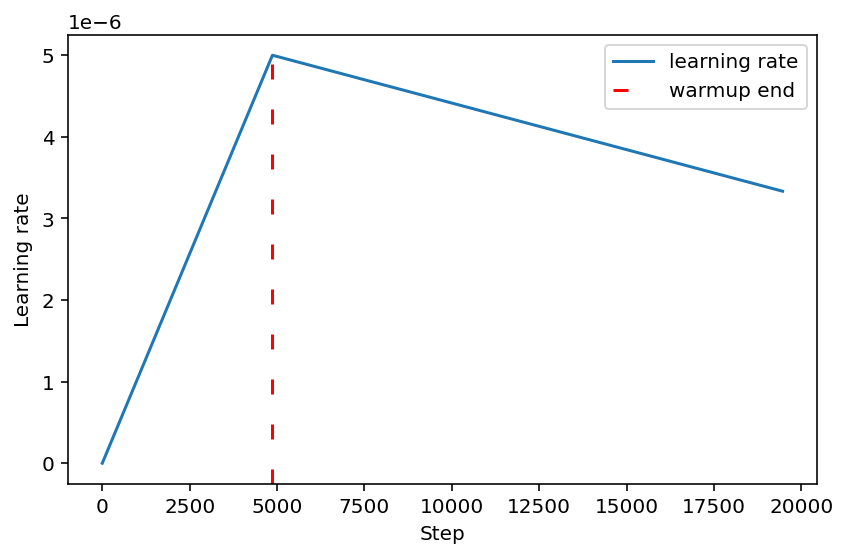

In [30]:
def train(model, train_data, val_data, learning_rate, epochs):

    BATCH_SIZE = 2
    GRADIENT_ACCUMULATION_STEPS = 1
    NUM_TRAIN_EPOCHS = 10
    WARMUP_PROPORTION = 0.1
    learning_rate_history = []
    
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

    ## Defining scheduler
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=num_warmup_steps,
      num_training_steps=num_train_steps
    )

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
            learning_rate_history.append(optimizer.param_groups[0]['lr'])

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        

        PATH = os.path.join(BASE_DIR,f'models/model_state.save_{epoch_num}')
        
        torch.save({
            'epoch': epoch_num + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss_val / len(val_data),
            }, PATH)


    plt.plot(learning_rate_history, label="learning rate")
    plt.axvline(x=num_warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
    plt.legend()
    plt.xlabel("Step")
    plt.ylabel("Learning rate")
    plt.tight_layout();

EPOCHS = 4
model = BertClassifier()
LR = 5e-6
              
train(model, df_train, df_val, LR, EPOCHS)

### 3.  Avaluate Model

In [31]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.984


In [20]:
torch.save(model.state_dict(), os.path.join(BASE_DIR,f'models/model_final.save'))

In [30]:
## Pedict
def predict(txt):
    txt = str(txt)
    txt = clearText(txt)
    if(len(txt)) < 50:
        return 2
    
    THRESHOLD = 0.5

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    

    encoding = tokenizer.encode_plus(
      txt,
      truncation=True,
      add_special_tokens=True,
      max_length=512,
      #return_token_type_ids=False,
      padding="max_length",
      #return_attention_mask=True,
      return_tensors='pt',
    )

    mask = encoding['attention_mask'].to(device)
    input_id = encoding['input_ids'].squeeze(1).to(device)

    output = model(input_id,mask)
    #output.argmax(dim=1)
    preds = output.detach().cpu().numpy()
    pred_val = np.argmax(preds)
    pred_val = list(labels.keys())[list(labels.values()).index(pred_val)] 
    #print(pred_val)
    
    #result = [(labels[idx],item *100) for idx,item in enumerate(prob[0].tolist())]
    return pred_val


In [28]:
def clearText(text):
    text = str(text).strip().upper()
    text = text.encode('utf-8').decode('utf-8')
    # replace multiple spaces with a single space
    text = re.sub(' +', ' ', text)
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    text = re.sub(r'\((.*?)\)',' ',text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z . ! ? : \( \) , ; À Á Â Ã Ç È É Ê Ì Í Î Ò Ó Ô Õ Ù Ú Û  ])|(\w+:\/\/\S+)|^rt|http.+?|[.]{2,}", "", text)
    text = re.sub(r'\n',' ',text)
    return text


In [27]:
listTxtPredict = []
listTxtPredict.append('''XXXIV - são a todos assegurados, independentemente do pagamento de taxas:

a) o direito de petição aos Poderes Públicos em defesa de direitos ou contra ilegalidade ou abuso de poder;

b) a obtenção de certidões em repartições públicas, para defesa de direitos e esclarecimento de situações de interesse pessoal;

XXXV - a lei não excluirá da apreciação do Poder Judiciário lesão ou ameaça a direito;

XXXVI - a lei não prejudicará o direito adquirido, o ato jurídico perfeito e a coisa julgada;

XXXVII - não haverá juízo ou tribunal de exceção;

XXXVIII - é reconhecida a instituição do júri, com a organização que lhe der a lei, assegurados:

a) a plenitude de defesa;

b) o sigilo das votações;

c) a soberania dos veredictos;

d) a competência para o julgamento dos crimes dolosos contra a vida; ''')

listTxtPredict.append(''' A certificação ou sua renovação será concedida à entidade de assistência social que presta serviços ou realiza ações socioassistenciais, de forma gratuita, continuada e planejada, para os usuários e para quem deles necessitar, sem discriminação, observada a Lei nº 8.742, de 7 de dezembro de 1993 .

§ 1º Consideram-se entidades de assistência social aquelas que prestam, sem fins lucrativos, atendimento e assessoramento aos beneficiários abrangidos pela Lei nº 8.742, de 7 de dezembro de 1993 , e as que atuam na defesa e garantia de seus direitos.

§ 2º Observado o disposto no caput e no § 1º , também são consideradas entidades de assistência social:

I - as que prestam serviços ou ações socioassistenciais, sem qualquer exigência de contraprestação dos usuários, com o objetivo de habilitação e reabilitação da pessoa com deficiência e de promoção da sua inclusão à vida comunitária, no enfrentamento dos limites existentes para as pessoas com deficiência, de forma articulada ou não com ações educacionais ou de saúde;

II - as de que trata o inciso II do art. 430 da Consolidação das Leis do Trabalho (CLT), aprovada pelo Decreto-Lei nº 5.452, de 1º de maio de 1943, desde que os programas de aprendizagem de adolescentes, de jovens ou de pessoas com deficiência sejam prestados com a finalidade de promover a integração ao mercado de trabalho, nos termos da Lei nº 8.742, de 7 de dezembro de 1993, observadas as ações protetivas previstas na Lei nº 8.069, de 13 de julho de 1990 ; e

III - as que realizam serviço de acolhimento institucional provisório de pessoas e de seus acompanhantes, que estejam em trânsito e sem condições de autossustento, durante o tratamento de doenças graves fora da localidade de residência, observada a Lei nº 8.742, de 7 de dezembro de 1993. ''')


listTxtPredict.append('''Aplica-se às pessoas jurídicas de direito privado sem
finalidade de lucros, especialmente entidade imune,
isenta de impostos e contribuições para a seguridade
social, beneficente de assistência social e
atendimento aos Ministérios que, direta ou
indiretamente, têm relação com entidades sem
finalidade de lucros e, ainda, Receita Federal do
Brasil e demais órgãos federais, estaduais e
municipais.''')

listTxtPredict.append('''A entidade sem finalidade de lucros pode ser constituída sob a natureza jurídica de fundação
de direito privado, associação, organização social, organização religiosa, partido político e
entidade sindical.
3. A entidade sem finalidade de lucros pode exercer atividades, tais como as de assistência
social, saúde, educação, técnico-científica, esportiva, religiosa, política, cultural, beneficente,
social e outras, administrando pessoas, coisas, fatos e interesses coexistentes, e coordenados
em torno de um patrimônio com finalidade comum ou comunitária..''')


listTxtPredict.append('''Esta Interpretação aplica-se às pessoas jurídicas de direito privado sem finalidade de lucros,
especialmente entidade imune, isenta de impostos e contribuições para a seguridade social,
beneficente de assistência social e atendimento aos Ministérios que, direta ou indiretamente,
têm relação com entidades sem finalidade de lucros e, ainda, Receita Federal do Brasil e
demais órgãos federais, estaduais e municipais.
7. Esta Interpretação..''')


listTxtPredict.append('''A entidade sem finalidade de lucros deve constituir provisão em montante suficiente para
cobrir as perdas esperadas sobre créditos a receber, com base em estimativa de seus prováveis
valores de realização e baixar os valores prescritos, incobráveis e anistiados.''')


listTxtPredict.append('''A Lei nº 9.637 de 1998, que instituiu a primeira forma das organizações sociais de interesse público, deu ao conceito de terceiro setor contornos tecnicamente definidos, afirma Simões. Essa lei foi formulada de acordo com a perspectiva do antigo Ministério da Administração e Reforma do Estado, segundo o qual as atividades do Estado são as do Poder Executivo, Judiciário e Legislativo e Ministério Público são exclusivas, mas as não exclusivas, embora estatais, que configuram o terceiro setor podem realizar-se em convênio ou parceria com organizações privadas, como escolas, hospitais, centros de pesquisa, entidades assistenciais e empresas estatais, vinculadas ao mercado ''')


listTxtPredict.append('''Nesse mesmo sentido de entidades paralelas ao Estado, podem ser incluídas, hoje, além dos serviços sociais autônomos, também as entidades de apoio (em especial fundações, associações e cooperativas), as chamadas organizações sociais e as organizações da sociedade civil de interesse público.''')

In [31]:
for txtPredict in listTxtPredict:
    txtPredict = clearText(txtPredict)
    print(f'{txtPredict} -------------------------->  <b>{predict(txtPredict)}</b> \n')
    print('\n --------------- \n')

XXXIV   SÃO A TODOS ASSEGURADOS, INDEPENDENTEMENTE DO PAGAMENTO DE TAXAS:  A) O DIREITO DE PETIÇÃO AOS PODERES PÚBLICOS EM DEFESA DE DIREITOS OU CONTRA ILEGALIDADE OU ABUSO DE PODER;  B) A OBTENÇÃO DE CERTIDÕES EM REPARTIÇÕES PÚBLICAS, PARA DEFESA DE DIREITOS E ESCLARECIMENTO DE SITUAÇÕES DE INTERESSE PESSOAL;  XXXV   A LEI NÃO EXCLUIRÁ DA APRECIAÇÃO DO PODER JUDICIÁRIO LESÃO OU AMEAÇA A DIREITO;  XXXVI   A LEI NÃO PREJUDICARÁ O DIREITO ADQUIRIDO, O ATO JURÍDICO PERFEITO E A COISA JULGADA;  XXXVII   NÃO HAVERÁ JUÍZO OU TRIBUNAL DE EXCEÇÃO;  XXXVIII   É RECONHECIDA A INSTITUIÇÃO DO JÚRI, COM A ORGANIZAÇÃO QUE LHE DER A LEI, ASSEGURADOS:  A) A PLENITUDE DE DEFESA;  B) O SIGILO DAS VOTAÇÕES;  C) A SOBERANIA DOS VEREDICTOS;  D) A COMPETÊNCIA PARA O JULGAMENTO DOS CRIMES DOLOSOS CONTRA A VIDA; -------------------------->  <b>outros</b> 


 --------------- 

A CERTIFICAÇÃO OU SUA RENOVAÇÃO SERÁ CONCEDIDA À ENTIDADE DE ASSISTÊNCIA SOCIAL QUE PRESTA SERVIÇOS OU REALIZA AÇÕES SOCIOASSISTENCIAIS

In [52]:
predict(clearText(txtPredict[3]))

'terceiro_setor'

In [33]:
print(list(labels.keys())[list(labels.values()).index(0)])

outros


In [30]:
labels

{'outros': 0, 'terceiro_setor': 1}

In [ ]:
dfSampled = dfFull.copy()
logprint__('Cleaning texts: \n','...')
dfSampled["historico"] = dfSampled["historico"].apply(padraoNome)
dfSampled.info()

####### LOG: 22/06/2022 20:20:25 --> Cleaning texts: 
  ... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164644 entries, 0 to 164643
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   nr_empenho  164644 non-null  object
 1   historico   164644 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [ ]:
dfSampled['category'] = dfSampled["historico"].apply(predict)
dfSampled.category.value_counts()

0    162494
2      2021
1       129
Name: category, dtype: int64

In [ ]:
dfSampled[dfSampled['category']==1]

,nr_empenho,historico,category
62269,2021.3361.009.00031,Empenho destinado à celebração de convênio a s...,1
62236,2021.3361.009.00011,Empenho destinada a formalização de Convênio a...,1
116933,2021.2550.007.00015,Realização de convênio entre a Secretaria e Es...,1
53009,2022.1901.016.00126,Emenda Parlamentar Impositiva Número 2506 Muni...,1


In [ ]:
dfSampled.to_excel("/content/dataset/exec_IA_04_22062022.xlsx")